# Test `surface_current_tiles` Module

Render figure object produced by the `nowcast.figures.publish.surface_current_tiles` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_surface_current_tiles` worker.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the SalishSeaCast NEMO model results `/results/` parition mounted.

In [1]:
from glob import glob
import io
import os
from pathlib import Path

import arrow
from matplotlib.backends.backend_agg import FigureCanvas
import yaml

from nowcast.figures.publish import surface_current_tiles
from nowcast.figures.surface_current_domain import tile_coords_dic

In [2]:
%matplotlib inline

Python and library versions:

In [3]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import numpy
import sys
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.13.1 | packaged by conda-forge | (main, Jan 13 2025, 09:53:10) [GCC 13.3.0]'
numpy.__version__='2.2.2'
xarray.__version__='2025.1.1'
bottleneck.__version__='1.4.2'
h5netcdf.__version__='1.5.0'
h5py.__version__='3.12.1'
matplotlib.__version__='3.10.0'
cmocean.__version__='v3.0.3'


## Simulate Nowcast System Config

The `config` multiline string contains the pieces of `nowcast/config/nowcast.yaml`
that are needed to set up the conditions as `nowcast.workers.make_plots` does
before calling the figure module `make_figure()` function.

The `yaml.safe_load()` call at the bottom of the cell converts the string into a `config` dict.

The bits of `config/nowcast.yaml` that are required:

In [4]:
config = '''
    results archive:
        nowcast: /results/SalishSea/nowcast-blue.202111/
        forecast: /results/SalishSea/forecast.202111/

    figures:
        grid dir: /SalishSeaCast/grid/

    run types:
        forecast:
            coordinates: coordinates_seagrid_SalishSea201702.nc
            bathymetry: bathymetry_202108.nc
            mesh mask: mesh_mask202108.nc
'''

config = yaml.safe_load(io.StringIO(config))

The bits that the `make_surface_current_tiles` worker must provide:

In [5]:
run_type = "forecast"
run_date = arrow.get("2025-01-30")

dmy = run_date.format("DDMMMYY").lower()
dmym1 = run_date.shift(days=-1).format("DDMMMYY").lower()

results_dir0 = Path(config["results archive"][run_type], dmy)
results_dirm1 = Path(config["results archive"]["nowcast"], dmy)
results_dirm2 = Path(config["results archive"]["nowcast"], dmym1)

grid_dir = Path(config["figures"]["grid dir"])
coordf = grid_dir / config["run types"][run_type]["coordinates"]
mesh_maskf = grid_dir / config["run types"][run_type]["mesh mask"]
bathyf = grid_dir / config["run types"][run_type]["bathymetry"]

for results_dir in [results_dirm2, results_dirm1, results_dir0]:

    u_list = glob(os.fspath(results_dir) + "/SalishSea_1h_*_grid_U.nc")
    v_list = glob(os.fspath(results_dir) + "/SalishSea_1h_*_grid_V.nc")

    Uf = Path(u_list[0])
    Vf = Path(v_list[0])


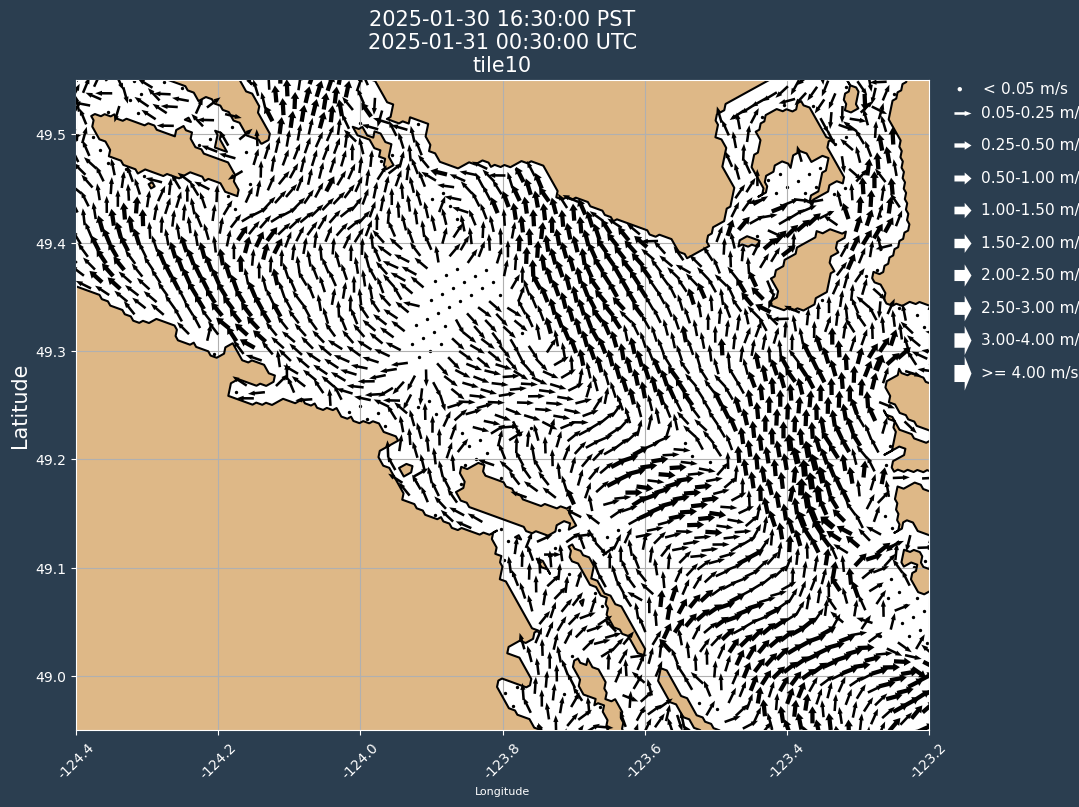

In [6]:
from importlib import reload
reload(surface_current_tiles)

t_index = 0
expansion_factor = 0.1  # 10% overlap for each tile

fig_list, tile_names = surface_current_tiles.make_figure(
    run_date,
    t_index,
    Uf,
    Vf,
    coordf,
    mesh_maskf,
    bathyf,
    tile_coords_dic,
    expansion_factor,
)
canvas = FigureCanvas(fig_list[9])
fig_list[9]